<a href="https://colab.research.google.com/github/ngcheeyuan/SPO1819/blob/master/SPO_1819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1 : Data cleaning

In [ ]:
pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 45.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=d7ad60d586a3bf8aa100b6fa64259341c173e2a31b1e9bd0b6fbe353706376b9
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from typing import Callable
import statsmodels.api as sm
from scipy import stats
import pylab as py
import datetime as dt
import pymc3 as pm
import pickle
import pylab

from pandas.api.types import CategoricalDtype


import operator

ops = {
    '+' : operator.add,
    '-' : operator.sub,
    '*' : operator.mul,
    '/' : operator.truediv,  # use operator.div for Python 2
    '%' : operator.mod,
    '^' : operator.xor,
    '==' : operator.eq,
    '>' : operator.gt,
    '>=' : operator.ge,
    '<' : operator.lt,
    '<=' : operator.lt
}

In [ ]:
df_m = pd.read_excel('Data 2018-2019.xlsx',sheet_name = 'Men')[['Bodyweight','Weight Cat','Age Cat','Gender','Best Squat','Best Bench','Best Deadlift','Total']]
df_w = pd.read_excel('Data 2018-2019.xlsx',sheet_name = 'Women')[['Bodyweight','Weight Cat','Age Cat','Gender','Best Squat','Best Bench','Best Deadlift','Total']]

In [ ]:
len(df_w)

115

In [ ]:
mask = df_w['Age Cat'].isin(['Sub-Junior + Open', 'Junior + Open','Master 1 + Open','Master 2 + Open'])
df_w[mask]

,Bodyweight,Weight Cat,Age Cat,Gender,Best Squat,Best Bench,Best Deadlift,Total
95,56.75,U57KG,Junior + Open,Women's,85.0,52.5,120.0,257.5


In [ ]:
mask = df_m['Age Cat'].isin(['Sub-Junior + Open', 'Junior + Open','Master 1 + Open','Master 2 + Open'])
df_m[mask]

,Bodyweight,Weight Cat,Age Cat,Gender,Best Squat,Best Bench,Best Deadlift,Total
206,58.85,U59KG,Sub-Junior + Open,Men's,135.0,70.0,180.0,385.0
214,65.05,U66KG,Junior + Open,Men's,177.5,117.5,207.5,502.5
244,158.20,120+KG,Junior + Open,Men's,300.0,150.0,300.0,750.0
246,103.40,U105KG,Master 2 + Open,Men's,240.5,145.0,245.0,630.5
250,117.25,U120KG,Master 1 + Open,Men's,225.0,155.0,237.5,617.5
253,102.75,U105KG,Master 1 + Open,Men's,210.0,145.0,210.0,565.0


In [ ]:
def df_logs(f):
  def wrapper(dataf, *args , **kwargs):
    tic = dt.datetime.now()
    result = f(dataf, *args , **kwargs)
    toc = dt.datetime.now()
    print(f'{f.__name__} took {toc - tic} , dataframe shape : {dataf.shape}')
    return result
  return wrapper

@df_logs
def copy_dataframe(df : pd.DataFrame) -> pd.DataFrame:
  return df.copy()

@df_logs
def rename(df : pd.DataFrame , name_dict : dict) -> pd.DataFrame:
  return df.rename(columns = name_dict)

@df_logs
def rename_column_items(df: pd.DataFrame , column : str , item_dict : dict) -> pd.DataFrame:
  df[column] = df[column].replace(item_dict)
  return df

@df_logs
def append_data(df: pd.DataFrame)-> pd.DataFrame:
  df_add = df[df.age_cat.isin(['Sub-Junior + Open', 'Junior + Open','Master 1 + Open','Master 2 + Open'])].copy()
  df_add.loc[:,'age_cat'] = 'Open'
  mask = df.age_cat.isin(['Sub-Junior + Open', 'Junior + Open','Master 1 + Open','Master 2 + Open'])
  df.loc[mask,'age_cat'] = df[mask].age_cat.apply(lambda x : re.sub(r'Master ','Master-',x)).apply(lambda x : re.sub(r' \+ Open','',x))
  df_return = df.append(df_add)
  df_return= df_return.reset_index(drop = True)
  return df_return

@df_logs
def column_apply(df:pd.DataFrame , column : str , lambda_func) -> pd.DataFrame:
  df[column] = df[column].copy().apply(lambda_func)
  return df

@df_logs
def remove_data(df:pd.DataFrame, column : str , condition_str : str) -> pd.DataFrame:
   oper , op = condition_str.split()
   op = int(op)
   df_return = df.drop((df.loc[ops[oper](df[column],op)].index))
   return df_return

def to_categorical(df:pd.DataFrame , column : str , cat_order : list = None) -> pd.DataFrame:
  if cat_order:
    cat_list = cat_order
  else:
    cat_list = list(df[column].unique())

  df[column] = pd.Categorical(df[column] , ordered = True ,categories = cat_list)
  return df

In [ ]:
df_men = df_m.pipe(copy_dataframe)\
             .pipe(rename, name_dict ={'Bodyweight':'bw','Weight Cat':'weight_cat','Age Cat':'age_cat','Gender':'gender','Best Squat':'s','Best Bench':'b','Best Deadlift':'d','Total':'total'})\
             .pipe(rename_column_items , column = 'age_cat' , item_dict = {'Sub Junior':'Sub-Junior',
                                                                           'Master 1':'Master-1',
                                                                           'Master 2':'Master-2',
                                                                           'Masters 2':'Master-2',
                                                                           'Master 3':'Master-3'})\
             .pipe(rename_column_items , column = 'gender' , item_dict ={'Men':'m',
                                                                         "Men's":'m',
                                                                         "Male":'m'} )\
             .pipe(append_data)\
             .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub("Men's ",'',x))\
             .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub('U','',x))\
             .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub("KG",'',x))\
             .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub(" ",'',x))\
             .pipe(remove_data, column = 'total' , condition_str = '== 0')\
             .pipe(to_categorical, column = 'weight_cat')\
             .pipe(to_categorical, column = 'age_cat' , cat_order =['Sub-Junior','Junior','Open','Master-1','Master-2','Master-3'])

copy_dataframe took 0:00:00.000223 , dataframe shape : (298, 8)
rename took 0:00:00.000974 , dataframe shape : (298, 8)
rename_column_items took 0:00:00.003836 , dataframe shape : (298, 8)
rename_column_items took 0:00:00.001615 , dataframe shape : (298, 8)
append_data took 0:00:00.014286 , dataframe shape : (298, 8)
column_apply took 0:00:00.001840 , dataframe shape : (304, 8)
column_apply took 0:00:00.001623 , dataframe shape : (304, 8)
column_apply took 0:00:00.002030 , dataframe shape : (304, 8)
column_apply took 0:00:00.001642 , dataframe shape : (304, 8)
remove_data took 0:00:00.001792 , dataframe shape : (304, 8)


In [ ]:
df_women = df_w.pipe(copy_dataframe)\
               .pipe(rename, name_dict ={'Bodyweight':'bw','Weight Cat':'weight_cat','Age Cat':'age_cat','Gender':'gender','Best Squat':'s','Best Bench':'b','Best Deadlift':'d','Total':'total'})\
               .pipe(rename_column_items , column = 'age_cat' , item_dict = {'Sub Junior':'Sub-Junior',
                                                                             'Master 1':'Master-1',
                                                                             'Master 2':'Master-2',
                                                                             'Masters 2':'Master-2',
                                                                             'Master 3':'Master-3'})\
               .pipe(rename_column_items , column = 'gender' , item_dict = {'Women':'f',
                                                                            "Women's":'f',
                                                                            'Female':'f'})\
               .pipe(append_data)\
               .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub("Women's ",'',x))\
               .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub('U','',x))\
               .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub("KG",'',x))\
               .pipe(column_apply, column = 'weight_cat' , lambda_func = lambda x : re.sub(" ",'',x))\
               .pipe(remove_data, column = 'total', condition_str = '== 0')\
               .pipe(to_categorical, column = 'weight_cat')\
               .pipe(to_categorical, column = 'age_cat' , cat_order = ['Sub-Junior','Junior','Open','Master-1','Master-2','Master-3'])

copy_dataframe took 0:00:00.000207 , dataframe shape : (115, 8)
rename took 0:00:00.000818 , dataframe shape : (115, 8)
rename_column_items took 0:00:00.001518 , dataframe shape : (115, 8)
rename_column_items took 0:00:00.001144 , dataframe shape : (115, 8)
append_data took 0:00:00.005454 , dataframe shape : (115, 8)
column_apply took 0:00:00.001135 , dataframe shape : (116, 8)
column_apply took 0:00:00.000966 , dataframe shape : (116, 8)
column_apply took 0:00:00.002671 , dataframe shape : (116, 8)
column_apply took 0:00:00.004695 , dataframe shape : (116, 8)
remove_data took 0:00:00.002297 , dataframe shape : (116, 8)


In [ ]:
order = ['Sub-Junior','Junior','Open','Master-1','Master-2','Master-3']

In [ ]:
mask = df_men['s'] == 0
df_men[mask]

,bw,weight_cat,age_cat,gender,s,b,d,total
68,64.85,66,Sub-Junior,m,0.0,90.0,180.0,270.0
155,73.35,74,Junior,m,0.0,100.0,160.0,260.0
229,64.40,66,Junior,m,0.0,0.0,180.0,180.0
291,82.30,83,Open,m,0.0,110.0,210.0,320.0


In [ ]:
mask = df_men['b'] == 0
df_men[mask]

,bw,weight_cat,age_cat,gender,s,b,d,total
16,63.8,66,Junior,m,145.0,0.0,210.0,355.0
106,82.2,83,Open,m,185.0,0.0,0.0,185.0
182,91.6,93,Open,m,277.5,0.0,252.5,530.0
227,64.6,66,Sub-Junior,m,130.0,0.0,180.0,310.0
229,64.4,66,Junior,m,0.0,0.0,180.0,180.0
290,96.9,93,Open,m,185.0,0.0,205.0,390.0


In [ ]:
mask = df_men['d'] == 0
df_men[mask]

,bw,weight_cat,age_cat,gender,s,b,d,total
33,81.05,83,Master-1,m,200.0,115.0,0.0,315.0
65,56.30,59,Open,m,130.0,70.0,0.0,200.0
106,82.20,83,Open,m,185.0,0.0,0.0,185.0
228,63.95,66,Open,m,157.5,87.5,0.0,245.0
274,86.50,83,Open,m,160.0,110.0,0.0,270.0


In [ ]:
mask = df_women['d'] == 0
df_women[mask]

,bw,weight_cat,age_cat,gender,s,b,d,total
49,46.85,47,Junior,f,90.0,45.0,0.0,135.0


In [ ]:
df_men.loc[(df_men['s']>0)]

,bw,weight_cat,age_cat,gender,s,b,d,total
0,51.35,53,Junior,m,110.0,82.5,145.0,337.5
1,58.40,59,Sub-Junior,m,127.5,105.5,165.0,398.0
2,56.70,59,Sub-Junior,m,145.0,77.5,160.0,382.5
3,57.90,59,Sub-Junior,m,122.5,67.5,125.0,315.0
4,58.30,59,Sub-Junior,m,105.0,70.0,120.0,295.0
...,...,...,...,...,...,...,...,...
299,65.05,66,Open,m,177.5,117.5,207.5,502.5
300,158.20,120+,Open,m,300.0,150.0,300.0,750.0
301,103.40,105,Open,m,240.5,145.0,245.0,630.5
302,117.25,120,Open,m,225.0,155.0,237.5,617.5


In [ ]:
df_men.weight_cat.unique()

['53', '59', '66', '74', '83', '93', '105', '120', '120+']
Categories (9, object): ['53' < '59' < '66' < '74' ... '93' < '105' < '120' < '120+']

## Section 2 : EDA

In [ ]:
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def standardize(df):
    mean = df.mean()
    std = df.std()
    result= (df - mean)/std
    return result

def sharp_test(x):
  if len(x) < 3:
    return ('sample_size < 3 , unable to test')
  sharp_test.__name__ = 'shapiro-wilk-test'
  test_statistic,p_value = stats.shapiro(x)

  if p_value < 0.05:
    accept_reject = f'reject null , p-value : {p_value}'
  else:
    accept_reject = f'accept null , p-value : {p_value}'
  return (f'test_statistic :{test_statistic}' , accept_reject)


def summary_table(df:pd.DataFrame,group:str,group_order: list) -> pd.DataFrame : 
  return pd.concat([\
  df.loc[(df['s']>0)].groupby(group).agg({'s':[sharp_test,'count','min',percentile(25),percentile(50),percentile(75),'max','mean','std']}).reindex(group_order),\
  df.loc[(df['b']>0)].groupby(group).agg({'b':[sharp_test,'count','min',percentile(25),percentile(50),percentile(75),'max','mean','std']}).reindex(group_order),\
  df.loc[(df['d']>0)].groupby(group).agg({'d':[sharp_test,'count','min',percentile(25),percentile(50),percentile(75),'max','mean','std']}).reindex(group_order),\
  df.loc[(df['total']>0)].groupby(group).agg({'total':[sharp_test,'count','min',percentile(25),percentile(50),percentile(75),'max','mean','std']}).reindex(group_order)]\
            ,axis = 1)

In [ ]:
from pandas.api.types import CategoricalDtype
cat_list = ['Sub-Junior','Junior','Open','Master-1','Master-2','Master-3']
men_weight_cat = list(df_men.weight_cat.unique())
women_weight_cat = list(df_women.weight_cat.unique())
cat_type = CategoricalDtype(categories=cat_list, ordered=True)
men_weight_cat_type = CategoricalDtype(categories=men_weight_cat, ordered=True)
women_weight_cat_type = CategoricalDtype(categories=women_weight_cat, ordered=True)

In [ ]:
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2

    return (ssb / (ssb + ssw))**.5

In [ ]:
print(f"s: {correlation_ratio(df_men['age_cat'],df_men['s'])}")
print(f"b: {correlation_ratio(df_men['age_cat'],df_men['b'])}")
print(f"d: {correlation_ratio(df_men['age_cat'],df_men['d'])}")

s: 0.23236276726381586
b: 0.32630058264965245
d: 0.19246272059652594


In [ ]:
print(f"s: {correlation_ratio(df_women['age_cat'],df_men['s'])}")
print(f"b: {correlation_ratio(df_women['age_cat'],df_men['b'])}")
print(f"d: {correlation_ratio(df_women['age_cat'],df_men['d'])}")

s: 0.19567100796206033
b: 0.20227443485424046
d: 0.1440544998295576


In [ ]:
print(f"s: {correlation_ratio(df_men['weight_cat'],df_men['s'])}")
print(f"b: {correlation_ratio(df_men['weight_cat'],df_men['b'])}")
print(f"d: {correlation_ratio(df_men['weight_cat'],df_men['d'])}")

s: 0.5688275794729415
b: 0.5257086724766613
d: 0.5043852934611879


In [ ]:
print(f"s: {correlation_ratio(df_women['weight_cat'],df_men['s'])}")
print(f"b: {correlation_ratio(df_women['weight_cat'],df_men['b'])}")
print(f"d: {correlation_ratio(df_women['weight_cat'],df_men['d'])}")

s: 0.2517777950621993
b: 0.32376593958905336
d: 0.24897560245966036


In [ ]:
def make_tables(df : pd.DataFrame , cat_type : list , weight_cat_type : list ) -> tuple :
  table = summary_table(df = df , group = ['age_cat','weight_cat'] , group_order = None)
  table_weight = summary_table(df = df , group = ['weight_cat'] , group_order = None)
  table_age = summary_table(df = df , group = ['age_cat'] , group_order = None)

  table = table.reset_index()
  table['age_cat'] = table['age_cat'].astype(cat_type)
  table['weight_cat'] = table['weight_cat'].astype(weight_cat_type)
  table = table.set_index(['age_cat','weight_cat'])
  table = table.sort_index()

  table_age = table_age.reset_index()
  table_age['age_cat'] = table_age['age_cat'].astype(cat_type)
  table_age = table_age.set_index('age_cat')
  table_age = table_age.sort_index()

  table_weight = table_weight.reset_index()
  table_weight['weight_cat'] = table_weight['weight_cat'].astype(weight_cat_type)
  table_weight = table_weight.set_index('weight_cat')
  table_weight = table_weight.sort_index()

  return (table,table_age,table_weight)

In [ ]:
def anova_test_tables(df : pd.DataFrame , group : list) -> pd.DataFrame :
  group_dict = {}
  for movement in ['s','b','d']:
    group_dict[movement] = df.loc[(df[movement]>0)].groupby(group)[movement].apply(list).to_dict()
    group_dict[movement] = {k:v for (k,v) in group_dict[movement].items() if len(v) > 3}

  return pd.DataFrame(group_dict)

In [ ]:
def one_way_test_results(df : pd.DataFrame) -> dict:
  anova_result = {}
  for movement in ['s','b','d']:
    movement_list = df[movement].to_list()
    test_statistic , p_value = f_oneway(*movement_list)
    anova_result[movement] = (f'test_statistic : {test_statistic} , p-value : {p_value} , {"reject" if p_value < 0.05 else "accept"}')
  return anova_result

In [ ]:
def one_way_anova_gender(df_1 : pd.DataFrame , df_2 : pd.DataFrame) -> pd.DataFrame :
  anova_result = {}
  for movement in ['s','b','d'] :
    test_statistic , p_value = f_oneway(df_1[movement],df_2[movement])
    anova_result[movement] = (f'test_statistic : {test_statistic} , p-value : {p_value} , {"reject" if p_value < 0.05 else "accept"}')
  return anova_result

In [ ]:
men_weight_anova = anova_test_tables(df_men , group = ['weight_cat'])
men_age_anova = anova_test_tables(df_men , group = ['age_cat'])
women_weight_anova = anova_test_tables(df_women , group = ['weight_cat'])
women_age_anova = anova_test_tables(df_women , group = ['age_cat'])

In [ ]:
from scipy.stats import f_oneway

In [ ]:
men_weight_result = one_way_test_results(men_weight_anova)
men_age_result = one_way_test_results(men_age_anova)
women_weight_result = one_way_test_results(women_weight_anova)
women_age_result = one_way_test_results(women_age_anova)
gender_result = one_way_anova_gender(df_men, df_women)

In [ ]:
consolidated_test_results = pd.DataFrame({'men_weight': men_weight_result,
                                          'men_age': men_age_result,
                                          'women_weight': women_weight_result,
                                          'women_age':women_age_result,
                                          'gender': gender_result})

In [ ]:
consolidated_test_results

,men_weight,men_age,women_weight,women_age,gender
s,"test_statistic : 26.59026734870644 , p-value :...","test_statistic : 3.604191279295647 , p-value :...","test_statistic : 6.315649223348348 , p-value :...","test_statistic : 7.840268324719625 , p-value :...","test_statistic : 388.8371373843884 , p-value :..."
b,"test_statistic : 26.24539807261738 , p-value :...","test_statistic : 12.884725959368833 , p-value ...","test_statistic : 8.83048803928932 , p-value : ...","test_statistic : 1.1913712894819999 , p-value ...","test_statistic : 491.2742820600582 , p-value :..."
d,"test_statistic : 21.808799001937953 , p-value ...","test_statistic : 4.319216168626136 , p-value :...","test_statistic : 7.293865417127357 , p-value :...","test_statistic : 5.073298644898158 , p-value :...","test_statistic : 362.76640621708765 , p-value ..."


In [ ]:
men,men_age,men_weight = make_tables(df_men , cat_type , men_weight_cat_type)
women,women_age,women_weight = make_tables(df_women , cat_type , women_weight_cat_type)

In [ ]:
with pd.ExcelWriter('normative_values_updated.xlsx') as writer:
      consolidated_test_results.to_excel(writer, sheet_name = 'one_way_anova_results')
      men.to_excel(writer, sheet_name='men_nv_age_&_weight')
      men_age.to_excel(writer,sheet_name = 'men_nv_age')
      men_weight.to_excel(writer,sheet_name = 'men_nv_weight')
      women.to_excel(writer, sheet_name='women_nv_age_&_weight')
      women_age.to_excel(writer,sheet_name ='women_nv_age')
      women_weight.to_excel(writer,sheet_name ='women_nv_weight')

In [ ]:
def box_plots(df:pd.DataFrame,g:str,order:list) -> None:
  f, ([squat,s2],[bench,b2],[deadlift,d2],[total,t2]) = plt.subplots(4,2, figsize = (28,15))
  f.suptitle(f"Powerlifting {g}" , size = 20)
  f.subplots_adjust(top=0.95)
  for m,movement,movement2 in zip(['s','b','d','total'],[squat,bench,deadlift,total],[s2,b2,d2,t2]):
    sns.boxplot(data = df.loc[df[m]>0], x = 'age_cat' , y = m , ax = movement , order = order)
    sns.boxplot(data = df.loc[df[m]>0], x = 'weight_cat' , y = m , ax = movement2)

In [ ]:
import openpyxl

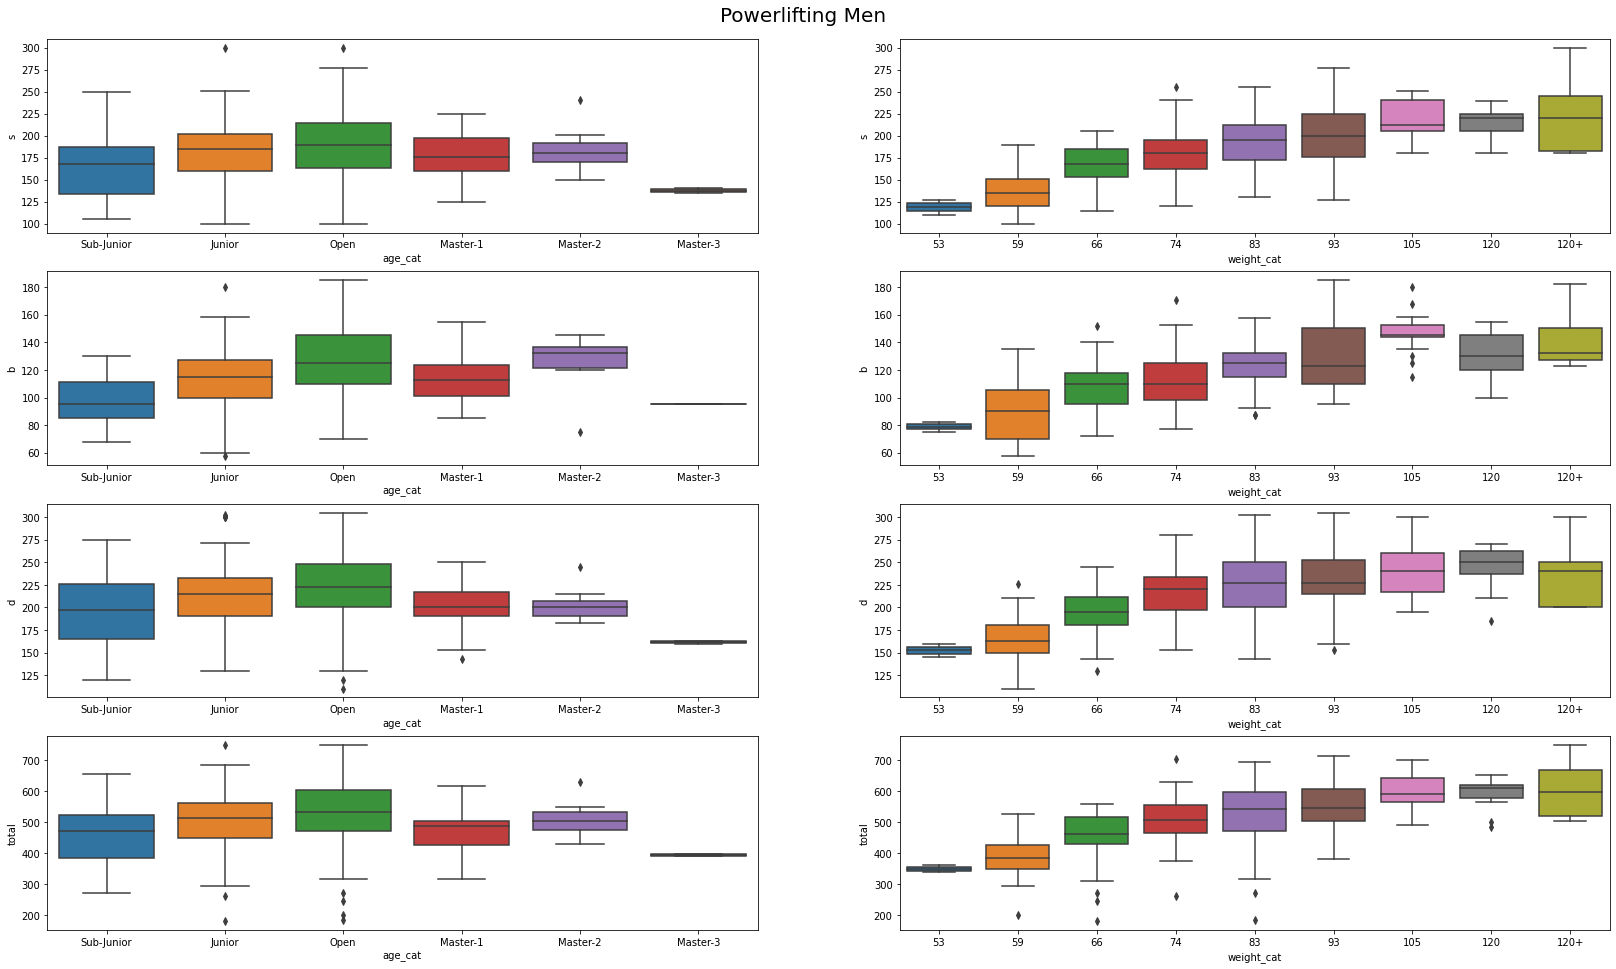

In [ ]:
box_plots(df = df_men , g = 'Men' , order = order )
plt.savefig("men_boxplot.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
wb.create_sheet('men_charts')
ws = wb['men_charts']

img = openpyxl.drawing.image.Image('men_boxplot.png')
img.anchor = 'A1'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
def kde_plots(df:pd.DataFrame,g:str,hue_order:list,category:str) -> None:
  f, ([squat,bench,deadlift,total],[squat_ecdf,bench_ecdf,deadlift_ecdf,total_ecdf]) = plt.subplots(2, 4 , figsize = (28,9))
  f.suptitle(f"Powerlifting {g} - {category}" , size = 30)
  f.subplots_adjust(top=0.9)
  for m,movement in zip(['s','b','d','total'],[squat,bench,deadlift,total]):
    sns.kdeplot(data = df.loc[df[m]>0], hue = category , x = m , ax = movement , hue_order = hue_order)
  for m,movement in zip(['s','b','d','total'],[squat_ecdf,bench_ecdf,deadlift_ecdf,total_ecdf]):
    sns.ecdfplot(data = df.loc[df[m]>0], hue = category , x = m , ax = movement , hue_order = hue_order)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


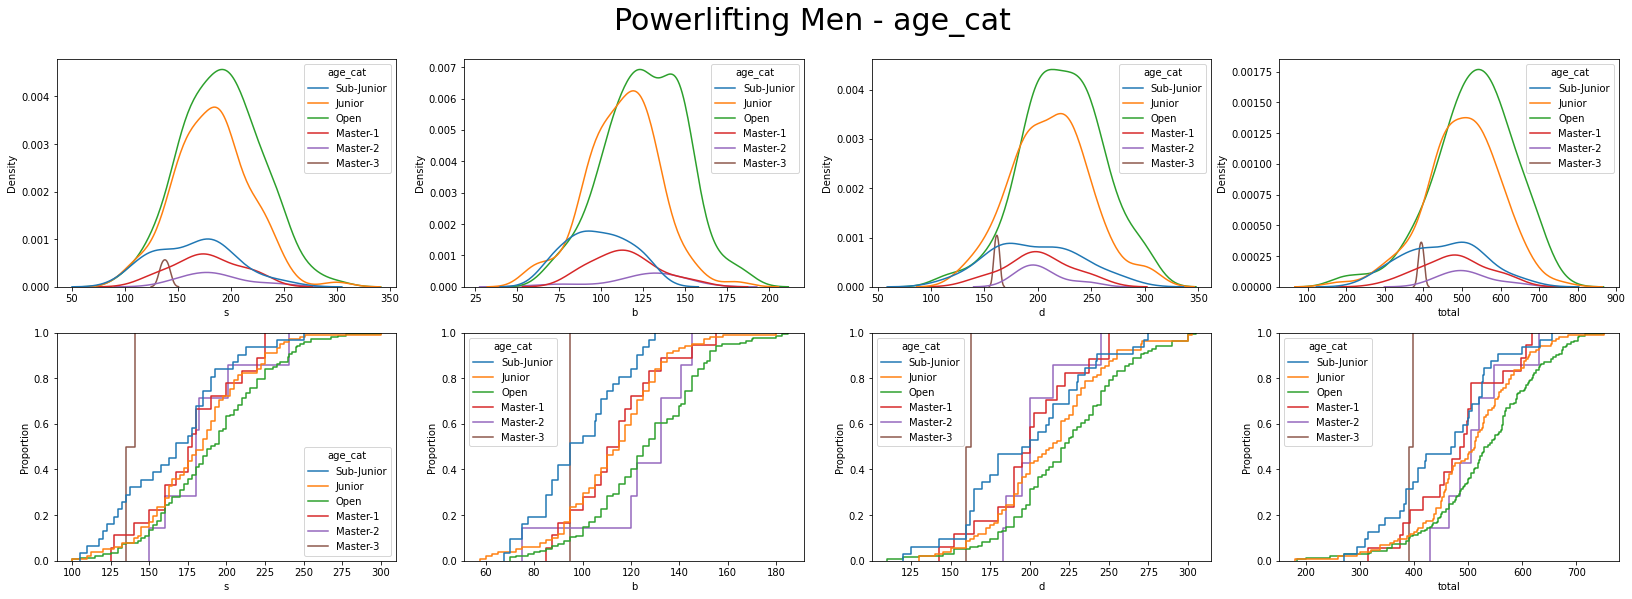

In [ ]:
kde_plots(df = df_men,g = 'Men',category ='age_cat', hue_order = order)
plt.savefig("men_kdeplot.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['men_charts']

img = openpyxl.drawing.image.Image('men_kdeplot.png')
img.anchor = 'A45'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

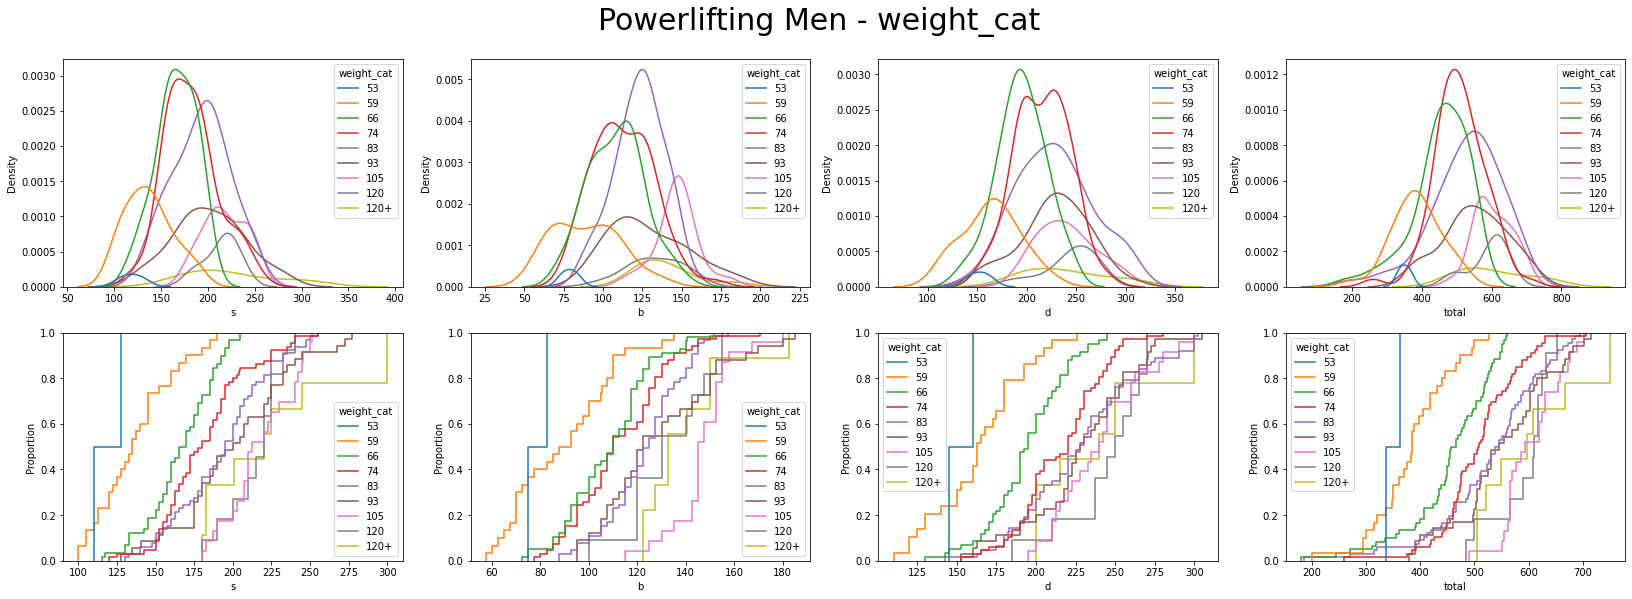

In [ ]:
kde_plots(df = df_men,g = 'Men',category ='weight_cat', hue_order = None)
plt.savefig("men_kdeplot_weight.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['men_charts']

img = openpyxl.drawing.image.Image('men_kdeplot_weight.png')
img.anchor = 'A75'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
women = summary_table(df = df_women , group = 'age_cat', group_order = cat_list)
women

s              \
                                            shapiro-wilk-test count   min   
age_cat                                                                     
Sub-Junior  (test_statistic :0.9568653106689453, accept nu...     8  65.0   
Junior      (test_statistic :0.9786038994789124, accept nu...    31  70.0   
Open        (test_statistic :0.963965654373169, reject nul...    68  55.0   
Master-1    (test_statistic :0.884670615196228, accept nul...     6  85.0   
Master-2                     sample_size < 3 , unable to test     1  85.0   
Master-3                     sample_size < 3 , unable to test     2  55.0   

                                                                         \
           percentile_25 percentile_50 percentile_75    max        mean   
age_cat                                                                   
Sub-Junior        71.875         76.25        84.375   97.5   78.750000   
Junior            88.750         95.00       105.000  130.0   96.177419   
Open              94.375        107.50       120.000  175.0  108.036765   
Master-1          90.000         95.00       100.000  103.0   94.666667   
Master-2          85.000         85.00        85.000   85.0   85.000000   
Master-3          56.875         58.75        60.625   62.5   58.750000   

                                                                       b  ...  \
                  std                                  shapiro-wilk-test  ...   
age_cat                                                                   ...   
Sub-Junior  10.773645  (test_statistic :0.935070812702179, accept nul...  ...   
Junior      14.326868  (test_statistic :0.9741737842559814, accept nu...  ...   
Open        21.390700  (test_statistic :0.9647108316421509, accept nu...  ...   
Master-1     7.257180  (test_statistic :0.8241714835166931, accept nu...  ...   
Master-2          NaN                   sample_size < 3 , unable to test  ...   
Master-3     5.303301                   sample_size < 3 , unable to test  ...   

                    d                                              total  \
                  std                                  shapiro-wilk-test   
age_cat                                                                    
Sub-Junior  19.250116  (test_statistic :0.8883847594261169, accept nu...   
Junior      19.140917  (test_statistic :0.9827863574028015, accept nu...   
Open        25.334543  (test_statistic :0.991718590259552, accept nul...   
Master-1    11.156463  (test_statistic :0.9151991605758667, accept nu...   
Master-2          NaN                   sample_size < 3 , unable to test   
Master-3     7.071068                   sample_size < 3 , unable to test   

                                                                          \
           count    min percentile_25 percentile_50 percentile_75    max   
age_cat                                                                    
Sub-Junior     8  190.0       205.000        216.75        236.75  285.5   
Junior        31  135.0       237.500        262.50        298.75  360.0   
Open          68  160.0       259.375        285.00        329.00  450.5   
Master-1       6  235.0       246.625        275.00        285.00  301.5   
Master-2       1  267.5       267.500        267.50        267.50  267.5   
Master-3       2  180.0       183.750        187.50        191.25  195.0   

                                   
                  mean        std  
age_cat                            
Sub-Junior  226.250000  32.222441  
Junior      265.032258  47.153461  
Open        293.588235  55.112161  
Master-1    268.666667  26.652705  
Master-2    267.500000        NaN  
Master-3    187.500000  10.606602  

[6 rows x 36 columns]

In [ ]:
weight_cat_women = df_women.weight_cat.unique()

In [ ]:
women = summary_table(df = df_women , group = 'weight_cat', group_order = weight_cat_women)
women

s               \
                                            shapiro-wilk-test count    min   
weight_cat                                                                   
43                           sample_size < 3 , unable to test     2   70.5   
47          (test_statistic :0.9606873989105225, accept nu...    11   75.0   
52          (test_statistic :0.9378641843795776, accept nu...    19   70.0   
57          (test_statistic :0.9711692929267883, accept nu...    37   55.0   
63          (test_statistic :0.9801173210144043, accept nu...    34   65.0   
72          (test_statistic :0.9309976100921631, accept nu...    10   80.0   
84                           sample_size < 3 , unable to test     2  110.0   
84+                          sample_size < 3 , unable to test     1   85.0   

                                                                         \
           percentile_25 percentile_50 percentile_75    max        mean   
weight_cat                                                                
43                71.125         71.75        72.375   73.0   71.750000   
47                87.500         90.00       101.250  110.0   93.227273   
52                81.250         90.00       105.000  125.0   93.684211   
57                85.000         97.50       115.000  132.5   98.378378   
63                96.250        104.00       112.500  132.5  104.500000   
72                99.375        127.50       152.750  175.0  127.150000   
84               112.500        115.00       117.500  120.0  115.000000   
84+               85.000         85.00        85.000   85.0   85.000000   

                                                                       b  ...  \
                  std                                  shapiro-wilk-test  ...   
weight_cat                                                                ...   
43           1.767767                   sample_size < 3 , unable to test  ...   
47          10.311071  (test_statistic :0.9382418394088745, accept nu...  ...   
52          17.487464  (test_statistic :0.9426697492599487, accept nu...  ...   
57          19.774916  (test_statistic :0.9776384234428406, accept nu...  ...   
63          14.572702  (test_statistic :0.9528731107711792, accept nu...  ...   
72          34.604953  (test_statistic :0.9199442267417908, accept nu...  ...   
84           7.071068                   sample_size < 3 , unable to test  ...   
84+               NaN                   sample_size < 3 , unable to test  ...   

                    d                                              total  \
                  std                                  shapiro-wilk-test   
weight_cat                                                                 
43           7.424621                   sample_size < 3 , unable to test   
47          10.082438  (test_statistic :0.8459346294403076, reject nu...   
52          28.415361  (test_statistic :0.9597504138946533, accept nu...   
57          23.402456  (test_statistic :0.9800560474395752, accept nu...   
63          17.726614  (test_statistic :0.9882455468177795, accept nu...   
72          20.405882  (test_statistic :0.9796323776245117, accept nu...   
84          12.374369                   sample_size < 3 , unable to test   
84+               NaN                   sample_size < 3 , unable to test   

                                                                          \
           count    min percentile_25 percentile_50 percentile_75    max   
weight_cat                                                                 
43             2  212.0       216.500         221.0       225.500  230.0   
47            11  135.0       226.750         242.5       255.250  283.0   
52            19  185.0       223.750         257.5       297.500  345.0   
57            37  160.0       228.000         272.5       297.500  370.5   
63            34  205.0       268.125         287.5       315.000  373.0   
72            10  252.5       310.625 

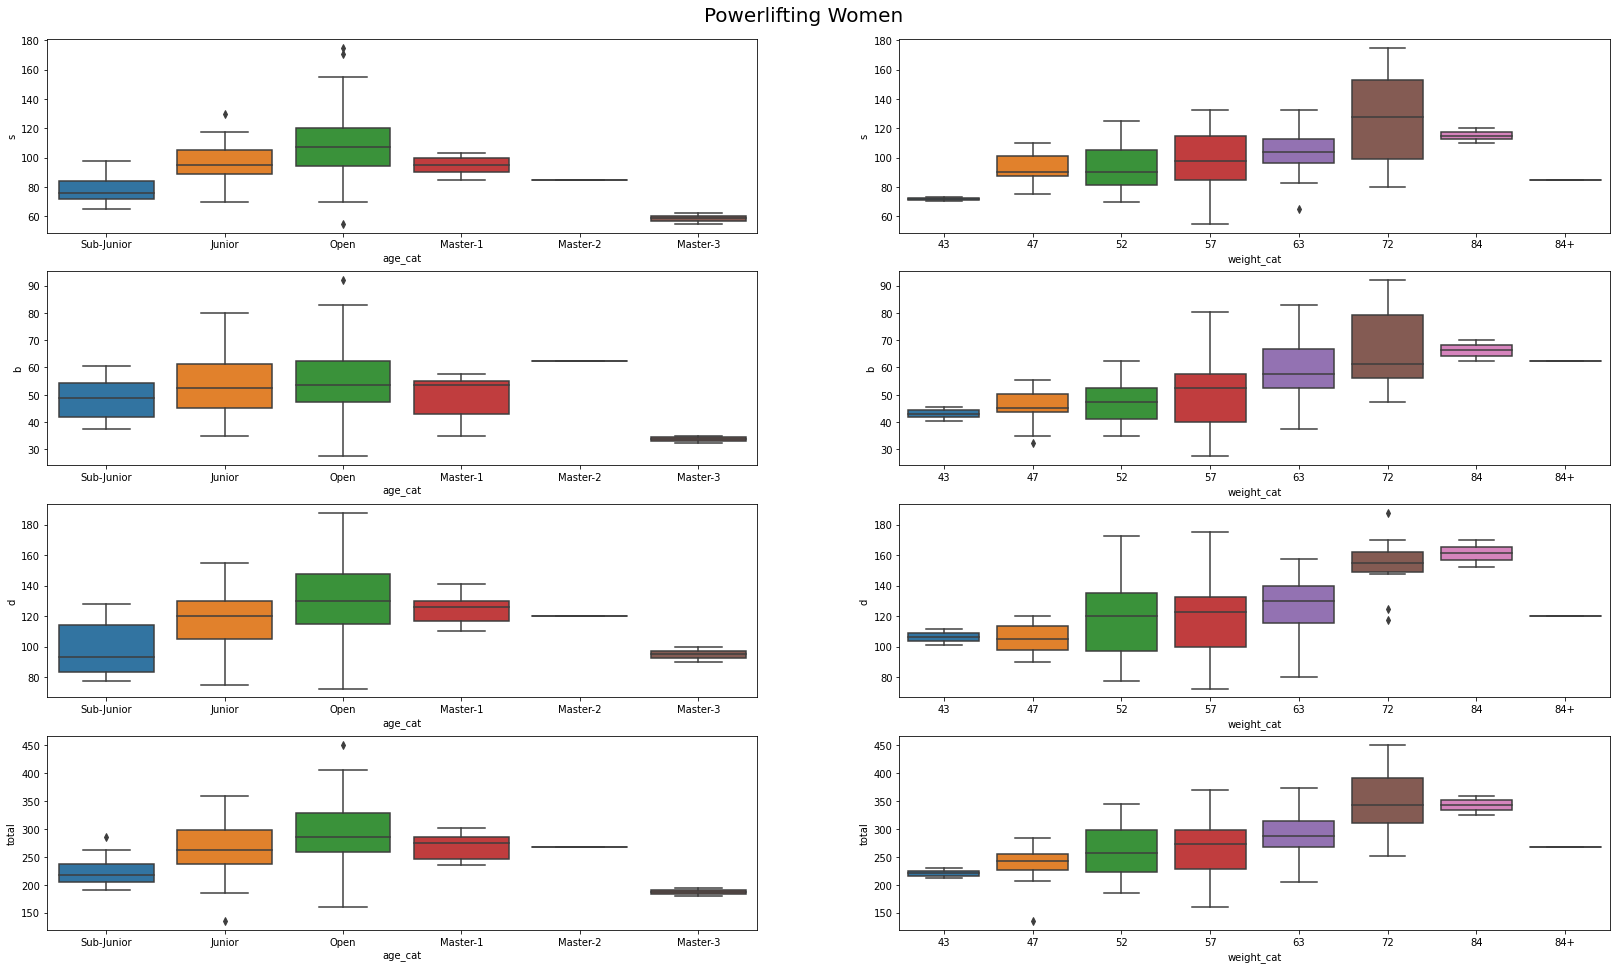

In [ ]:
box_plots(df = df_women , g = 'Women' , order = order)
plt.savefig("women_boxplot.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
wb.create_sheet('women_charts')
ws = wb['women_charts']

img = openpyxl.drawing.image.Image('women_boxplot.png')
img.anchor = 'A1'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


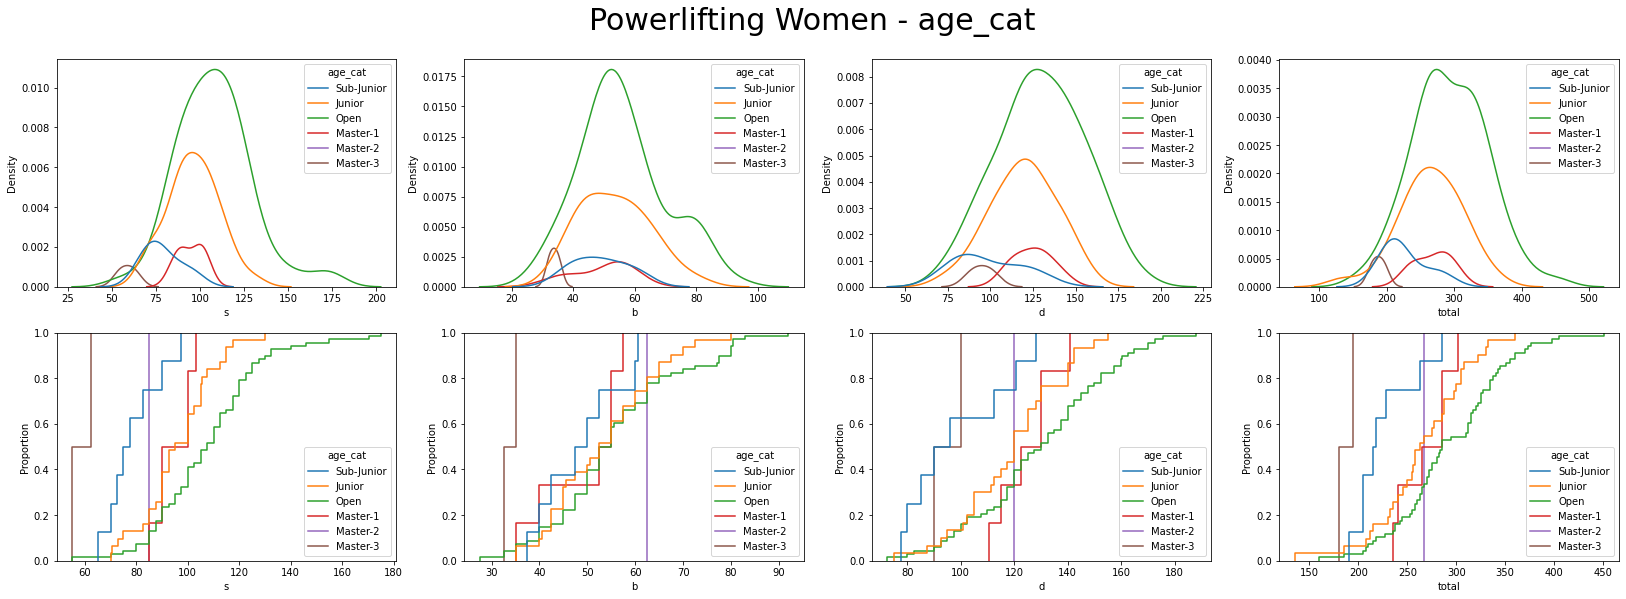

In [ ]:
kde_plots(df = df_women,g ='Women', category = 'age_cat',hue_order = order)
plt.savefig("women_kdeplot.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['women_charts']

img = openpyxl.drawing.image.Image('women_kdeplot.png')
img.anchor = 'A45'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


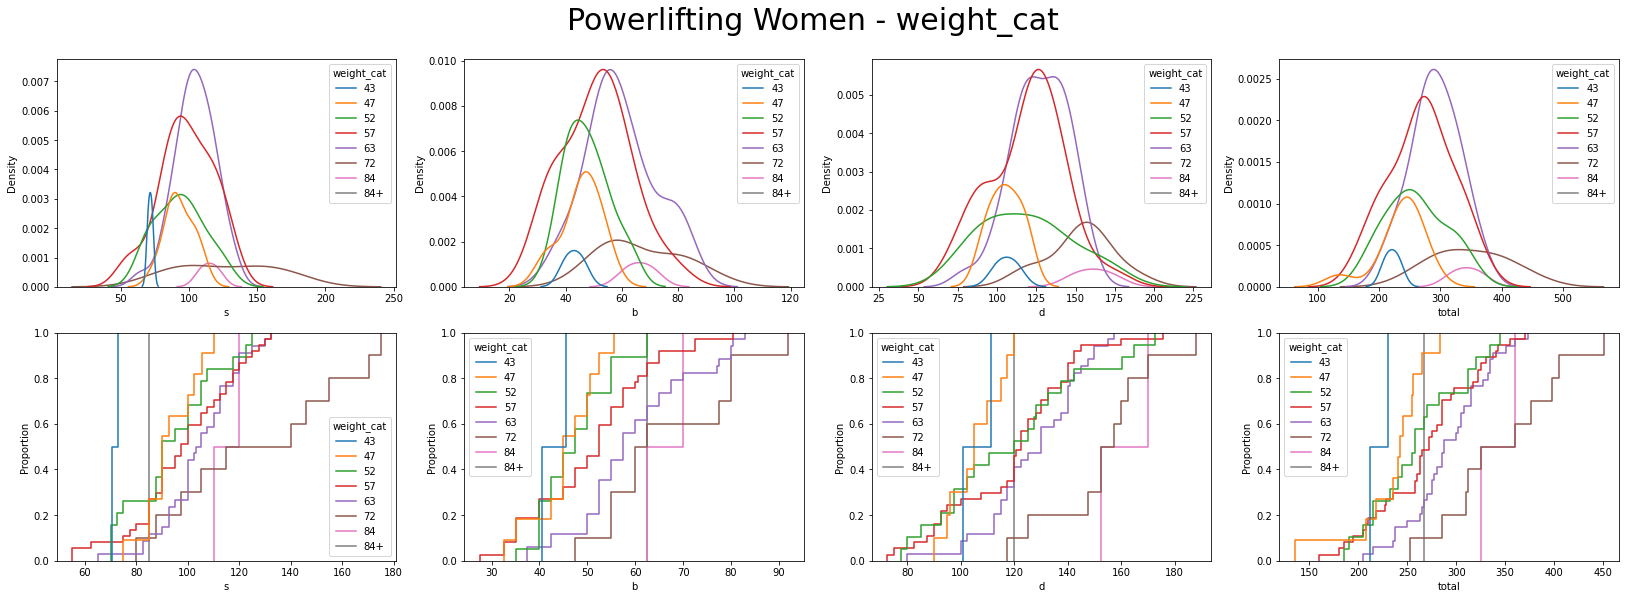

In [ ]:
kde_plots(df = df_women,g ='Women', category = 'weight_cat',hue_order = None)
plt.savefig("women_kdeplot_weight.png", dpi = 50)

wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['women_charts']

img = openpyxl.drawing.image.Image('women_kdeplot_weight.png')
img.anchor = 'A75'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
from itertools import chain
def find_small_samples(df : pd.DataFrame) -> set :
  final_list = []
  x = []
  for movement in ['s','b','d']:
    categories = df.loc[df[(movement,'count')]<3].index.to_list()
    final_list.append(categories)
  return  set(chain(*final_list))

In [ ]:
# removing data points that are in categories that are has too small a sample size
df_women_model = df_women.loc[~df_women['weight_cat'].isin(find_small_samples(women_weight))]
df_men_model = df_men.loc[~df_men['weight_cat'].isin(find_small_samples(men_weight))]

df_women_model['intercept'] = 1
df_men_model['intercept'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Section 3 : Model

In [ ]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [ ]:
def Model(Y_transformation : Callable[[None],None], 
          inverse_Y_transformation : Callable[[None],None]  ,
          X_transformation : Callable[[None],None]  ,
          df:pd.DataFrame,
          independent_variables:list,
          target : str) -> np.array:
  
  df = df[df[target]>0]
  X = df[independent_variables]
  if X_transformation:
    X = X_transformation(X)
  Y = df[target]
  if Y_transformation:
    original_y = Y
    Y = Y_transformation(Y)

  Model = sm.OLS(Y,X)
  results = Model.fit()

  ypred = results.predict(X)
  if Y_transformation:
    ypred = inverse_Y_transformation(ypred)
    Y = original_y
  error = rmse(Y,ypred)
  residuals = Y -ypred 

  print('Parameters: ', results.params)
  print('R2: ', results.rsquared)
  print(results.summary())
  print('RMSE: ', error)
  return ypred, X, residuals , error , results.rsquared

In [ ]:
def prediction_plot(df:pd.DataFrame,
                    predictions:list,
                    errors:list,
                    rsquared:list,
                    residuals:list,
                    g:str,
                    pic_name : str) -> None:

  f,([squat,squat_residuals],[bench,bench_residuals],[deadlift,deadlift_residuals]) = plt.subplots(3,2,figsize =(20,16))
  f.suptitle(f"Powerlifting {g} - Predictions vs Actual" , size = 20)
  f.subplots_adjust(top=0.9)

  for m,movement,residual_plot,ypred,rmse,rsquare,residual in zip(['s','b','d'],
                                                                    [squat,bench,deadlift],
                                                                    [squat_residuals,bench_residuals,deadlift_residuals],
                                                                    predictions,
                                                                    errors,
                                                                    rsquared,
                                                                    residuals):
    
    df_filtered = df.loc[df[m] > 0]
    sns.scatterplot(y = m , x = 'bw' , ax = movement , hue = 'weight_cat' , data = df_filtered)
    movement.legend(loc = 'lower right')
    movement.plot(df_filtered['bw'], ypred, color="red", linewidth=3)

    movement.text(0.2, 0.9, f'RMSE : {rmse:.2f}', horizontalalignment='center', verticalalignment='center', transform= movement.transAxes)
    if rsquare:
      movement.text(0.2, 0.85, f'R2 : {rsquare:.2f}', horizontalalignment='center', verticalalignment='center', transform= movement.transAxes)
    
    sm.qqplot( data = stats.zscore(residual),line = '45' , ax = residual_plot);
  plt.savefig(pic_name)

### <font size="5"> Model 0: </font>

<font size="5">Fitting line to equation: </font>
<font size="6"> <center> ${\hat{Movement}}= {\hat{B_1}}Bodyweight$ </font>

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , dependent_variables , residuals , error , params = Model(Y_transformation = None ,
                                                                          inverse_Y_transformation = None,
                                                                          X_transformation = None ,
                                                                          df = df_men_model,
                                                                          independent_variables = ['bw'],
                                                                          target = m)
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(params)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------
Parameters:  bw    2.278161
dtype: float64
R2:  0.9661588526772379
                                 OLS Regression Results                                
Dep. Variable:                      s   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              8422.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                   5.85e-219
Time:                        07:53:59   Log-Likelihood:                         -1468.8
No. Observations:                 296   AIC:                                      2940.
Df Residuals:                     295   BIC:                                      2943.
Df Model:                           1                                                  
Covariance Type:            nonrobust                          

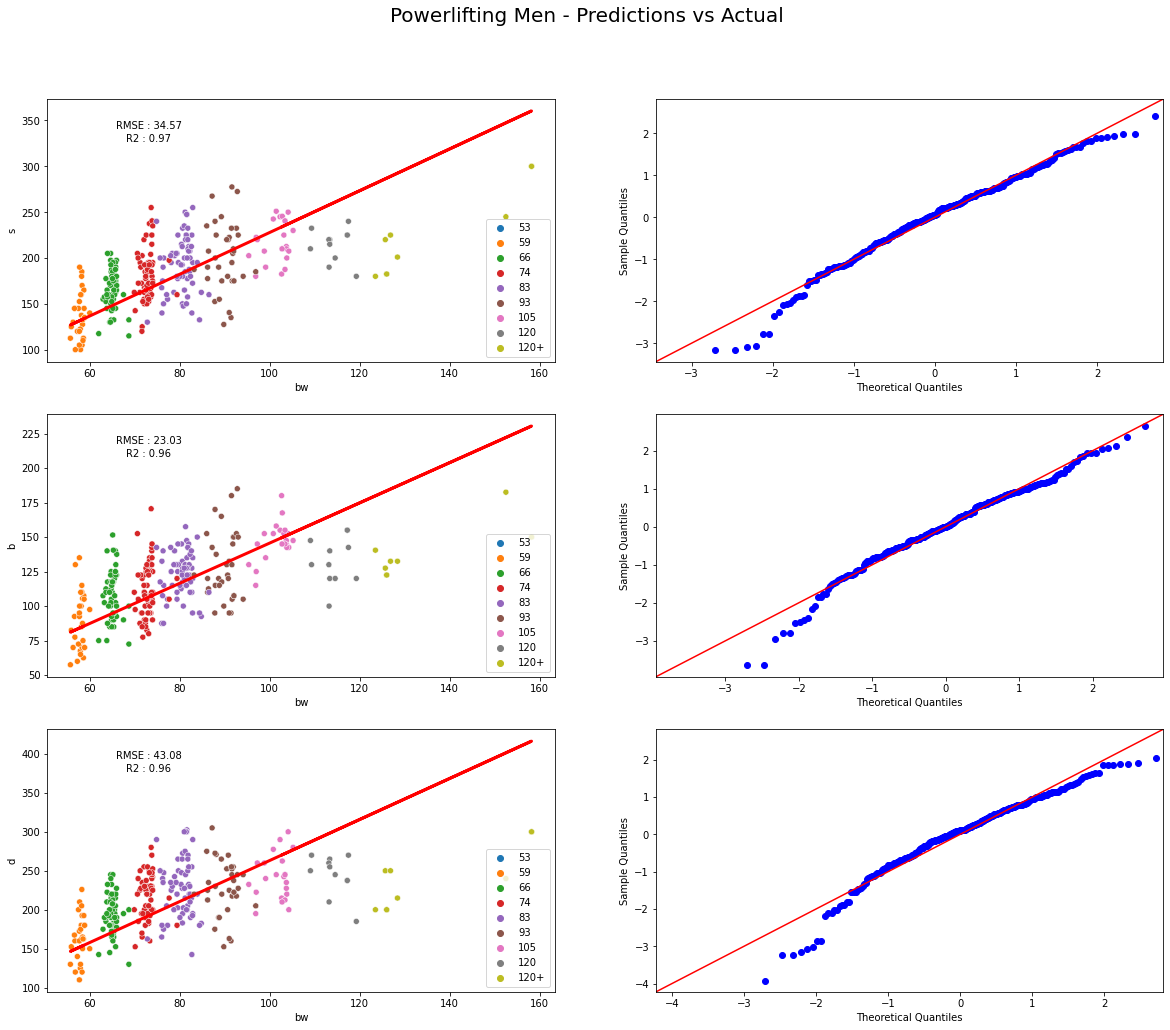

In [ ]:
prediction_plot(df_men_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Men',
                'men_model_1')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
wb.create_sheet('model_charts')
ws = wb['model_charts']

img = openpyxl.drawing.image.Image('men_model_1.png')
img.anchor = 'A1'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , dependent_variables , residuals , error , params = Model(Y_transformation = None ,
                                                                          inverse_Y_transformation = None,
                                                                          X_transformation = None ,
                                                                          df = df_women_model,
                                                                          independent_variables = ['bw'],
                                                                          target = m)
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(params)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------
Parameters:  bw    1.776423
dtype: float64
R2:  0.9681349015251766
                                 OLS Regression Results                                
Dep. Variable:                      s   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              3342.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                    3.71e-84
Time:                        07:54:02   Log-Likelihood:                         -481.36
No. Observations:                 111   AIC:                                      964.7
Df Residuals:                     110   BIC:                                      967.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                          

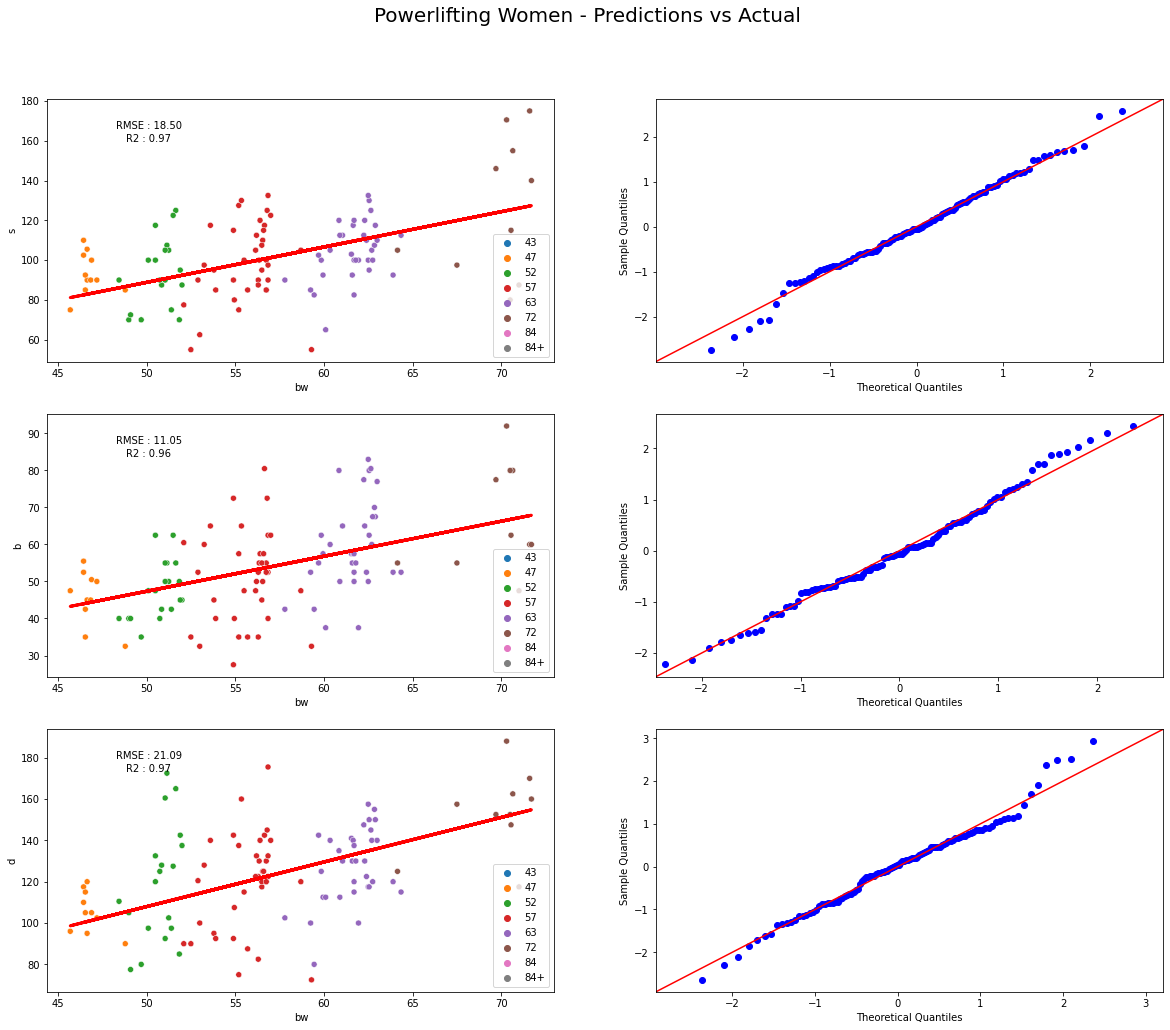

In [ ]:
prediction_plot(df_women_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Women',
                'women_model_1')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
wb.create_sheet('model_women_charts')
ws = wb['model_women_charts']

img = openpyxl.drawing.image.Image('women_model_1.png')
img.anchor = 'A1'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

### <font size="5"> Model 1: </font>

<font size="5">Fitting line to equation: </font>
<font size="6"> <center> $\sqrt{\hat{Movement} }= {\hat{B_1}}\sqrt[3]{Bodyweight}$ </font>

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , dependent_variables , residuals , error , params = Model(Y_transformation = np.sqrt ,
                                                                          inverse_Y_transformation = np.square,
                                                                          X_transformation = np.cbrt ,
                                                                          df = df_men_model,
                                                                          independent_variables = ['bw'],
                                                                          target = m)
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(params)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------
Parameters:  bw    3.160025
dtype: float64
R2:  0.9937440735083779
                                 OLS Regression Results                                
Dep. Variable:                      s   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          4.686e+04
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                        0.00
Time:                        07:54:04   Log-Likelihood:                         -441.17
No. Observations:                 296   AIC:                                      884.3
Df Residuals:                     295   BIC:                                      888.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                          

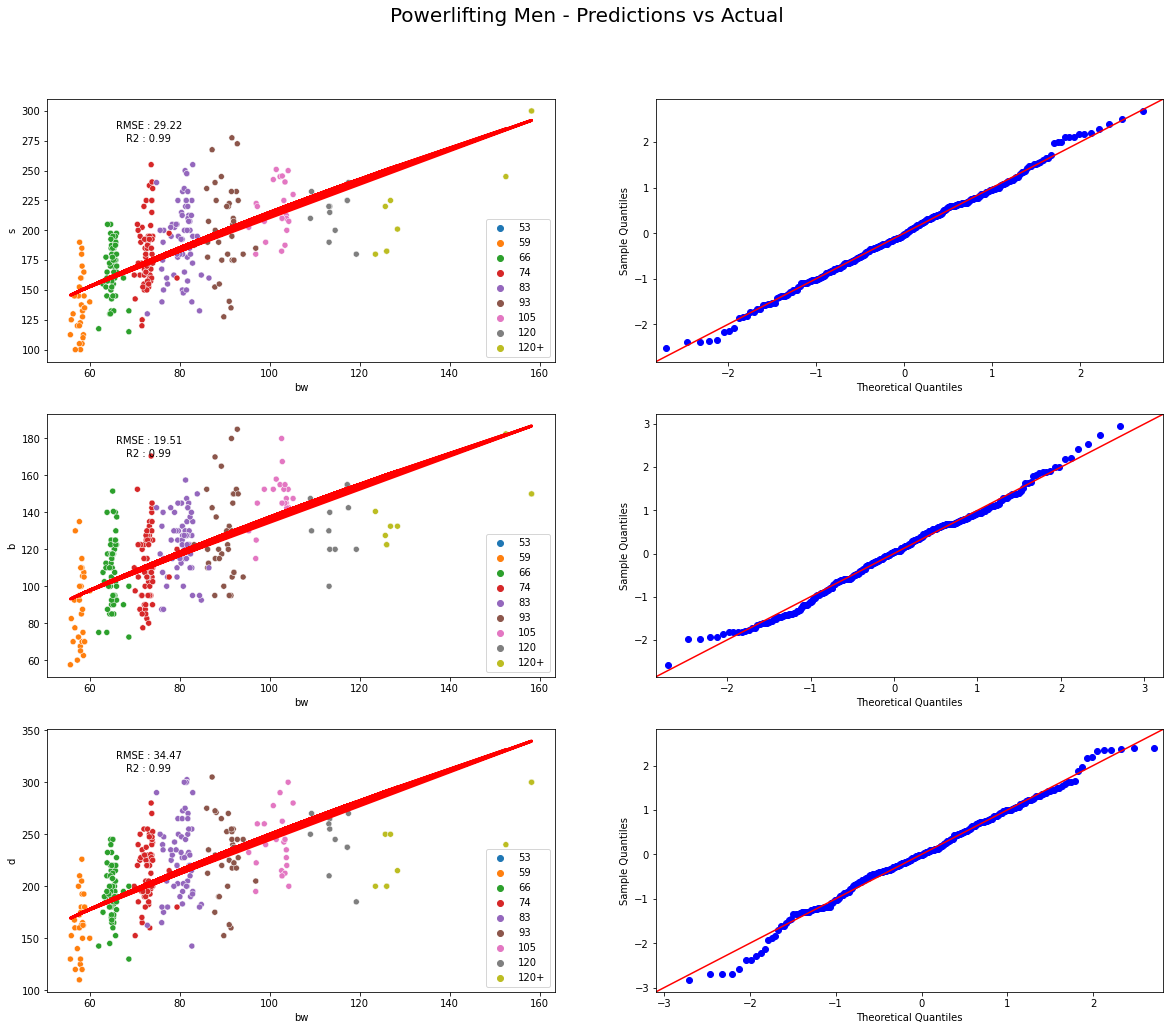

In [ ]:
prediction_plot(df_men_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Men',
                'men_model_2')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['model_charts']

img = openpyxl.drawing.image.Image('men_model_2.png')
img.anchor = 'A65'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , dependent_variables , residuals , error , params = Model(Y_transformation = np.sqrt ,
                                                                          inverse_Y_transformation = np.square,
                                                                          X_transformation = np.cbrt ,
                                                                          df = df_women_model,
                                                                          independent_variables = ['bw'],
                                                                          target = m)
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(params)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------
Parameters:  bw    2.608618
dtype: float64
R2:  0.9917091363169409
                                 OLS Regression Results                                
Dep. Variable:                      s   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.316e+04
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                   2.54e-116
Time:                        07:54:06   Log-Likelihood:                         -147.94
No. Observations:                 111   AIC:                                      297.9
Df Residuals:                     110   BIC:                                      300.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                          

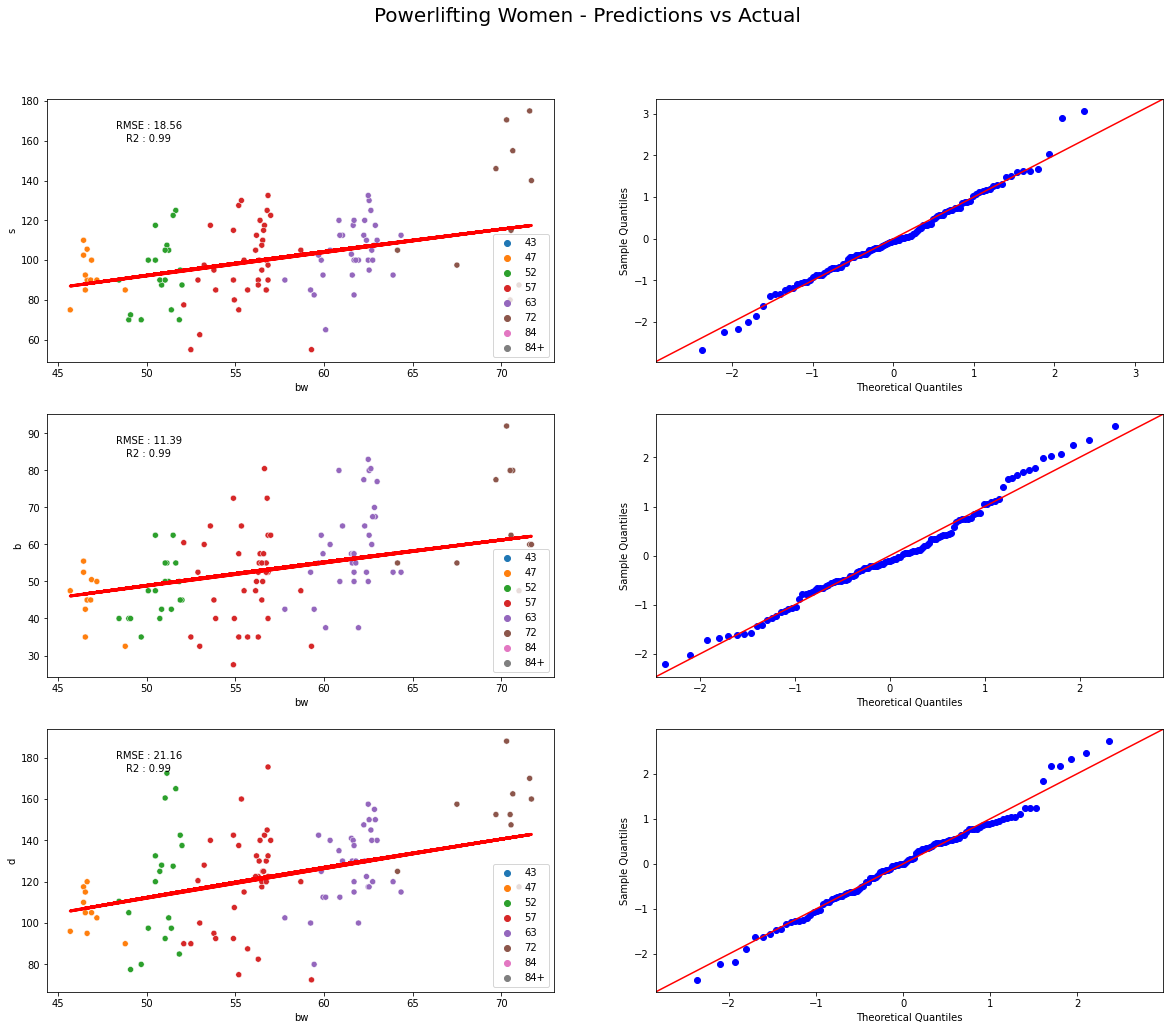

In [ ]:
prediction_plot(df_women_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Women',
                'women_model_2')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['model_women_charts']

img = openpyxl.drawing.image.Image('women_model_2.png')
img.anchor = 'A65'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
import statsmodels.formula.api as smf

### <font size="5"> Linear Mixed Mode ,  Model 2: </font>

<font size="5">Fitting line to equation: </font>
<font size="6"> <center> ${\hat{Movement_{i}}}= {\hat{\beta_0}} + \hat{\eta_{0i}} + ({\hat{\beta_1}} + \hat{\eta}_{1i})Bodyweight$ </font> 

In [ ]:
import statsmodels.formula.api as smf
def linear_mixed_model(df : pd.DataFrame ,
                       Y_transformation : Callable[[np.array] , np.array],
                       inverse_Y_transformation : Callable[[np.array] , np.array],
                       target : str,
                       formula : str , 
                       grp : str ,
                       re_slope : str) -> tuple :
  df = df.loc[df[target]>0] ## removing any participants that failed all attempts in that movement
  model = smf.mixedlm( formula , df , groups= df[grp] , re_formula = re_slope)
  results = model.fit(method = ['lbfgs'])
  ypred = results.predict()
  Y = df[target]

  if Y_transformation:
    ypred = inverse_Y_transformation(ypred)

  error = rmse(Y,ypred)
  residuals = Y - ypred
  params = results.params

  
  print('Parameters: ', results.params)
  print(f'RMSE : {error}')
  print(results.summary())

  return ypred , residuals , error , params

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , residuals , error , params = linear_mixed_model(Y_transformation = np.sqrt ,
                                                                inverse_Y_transformation = np.square,
                                                                df = df_men_model,
                                                                target = m,
                                                                formula = f'np.sqrt({m}) ~ np.sqrt(bw)',
                                                                grp = 'weight_cat',
                                                                re_slope = '~bw')
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(None)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------
Parameters:  Intercept         6.206520
np.sqrt(bw)       0.821787
Group Var         0.999620
Group x bw Cov   -0.010111
bw Var            0.000109
dtype: float64
RMSE : 29.06072626906571
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.sqrt(s)
No. Observations: 296     Method:             REML      
No. Groups:       8       Scale:              1.0653    
Min. group size:  9       Log-Likelihood:     -436.8106 
Max. group size:  65      Converged:          Yes       
Mean group size:  37.0                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       6.207    1.649 3.764 0.000  2.975  9.439
np.sqrt(bw)     0.822    0.179 4.600 0.000  0.472  1.172
Group Var       1.065                                   
Gro

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Parameters:  Intercept         4.083356
np.sqrt(bw)       0.764821
Group Var         1.584211
Group x bw Cov   -0.020600
bw Var            0.000269
dtype: float64
RMSE : 19.503747513331398
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.sqrt(b)
No. Observations: 294     Method:             REML      
No. Groups:       8       Scale:              0.7377    
Min. group size:  9       Log-Likelihood:     -379.5968 
Max. group size:  66      Converged:          Yes       
Mean group size:  36.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       4.083    1.481 2.758 0.006  1.181  6.985
np.sqrt(bw)     0.765    0.178 4.308 0.000  0.417  1.113
Group Var       1.169    1.067                          
Group x bw Cov -0.015    0.015                          
bw Var          0.000  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


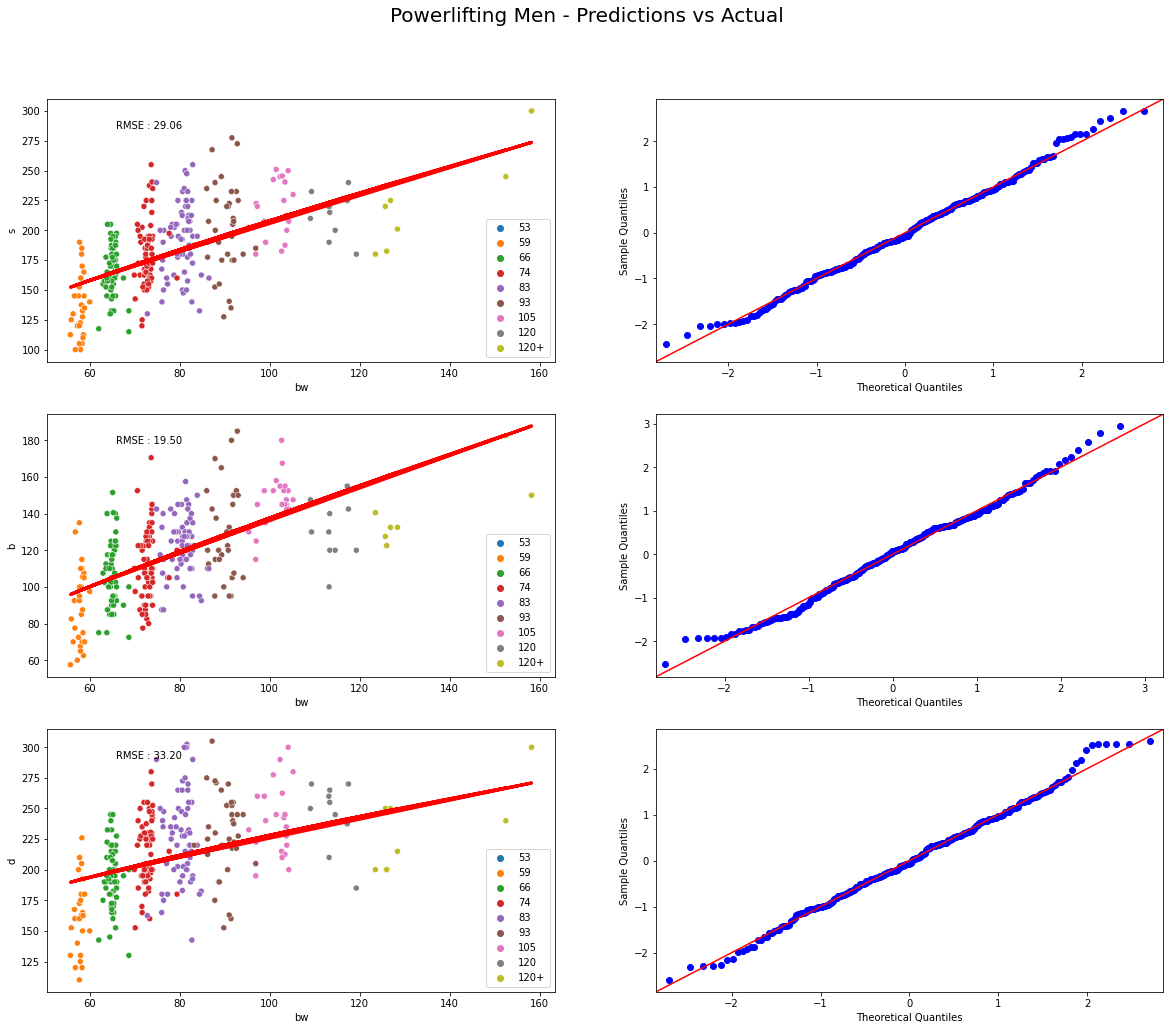

In [ ]:
prediction_plot(df_men_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Men',
                'men_model_3')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['model_charts']

img = openpyxl.drawing.image.Image('men_model_3.png')
img.anchor = 'A130'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
models_dict = {}
model_information = {'ypred_list':[],
                     'error_list':[],
                     'rsquared_list':[],
                     'residuals_list':[]}
for m,movement in zip(['s','b','d'],['Squat','Bench','Deadlift']):
  print(f'----------------------------------- {movement} -----------------------------------')
  predictions , residuals , error , params = linear_mixed_model(Y_transformation = np.sqrt ,
                                                                inverse_Y_transformation = np.square,
                                                                df = df_women_model,
                                                                target = m,
                                                                formula = f'np.sqrt({m}) ~ np.sqrt(bw)',
                                                                grp = 'weight_cat',
                                                                re_slope = '~bw')
  model_information['ypred_list'].append(predictions)
  model_information['error_list'].append(error)
  model_information['rsquared_list'].append(None)
  model_information['residuals_list'].append(residuals)

----------------------------------- Squat -----------------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.723291
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Parameters:  Intercept         2.178304
np.sqrt(bw)       1.038446
Group Var         0.984938
Group x bw Cov   -0.017457
bw Var            0.000309
dtype: float64
RMSE : 18.46275302438407
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.sqrt(s)
No. Observations: 111     Method:             REML      
No. Groups:       5       Scale:              0.8423    
Min. group size:  10      Log-Likelihood:     -149.5234 
Max. group size:  37      Converged:          No        
Mean group size:  22.2                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       2.178    1.348 1.616 0.106 -0.464  4.821
np.sqrt(bw)     1.038    0.161 6.438 0.000  0.722  1.355
Group Var       0.830    2.480                          
Group x bw Cov -0.015    0.041                          
bw Var          0.000   

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2711: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


Parameters:  Intercept        -0.733650
np.sqrt(bw)       1.062604
Group Var         1.008292
Group x bw Cov   -0.017643
bw Var            0.000309
dtype: float64
RMSE : 11.053631534605874
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.sqrt(b)
No. Observations: 111     Method:             REML      
No. Groups:       5       Scale:              0.5691    
Min. group size:  10      Log-Likelihood:     -128.1626 
Max. group size:  37      Converged:          Yes       
Mean group size:  22.2                                  
--------------------------------------------------------
                   Coef.  Std.Err. z P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept          -0.734                               
np.sqrt(bw)         1.063                               
Group Var           0.574                               
Group x bw Cov     -0.010                               
bw Var              0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


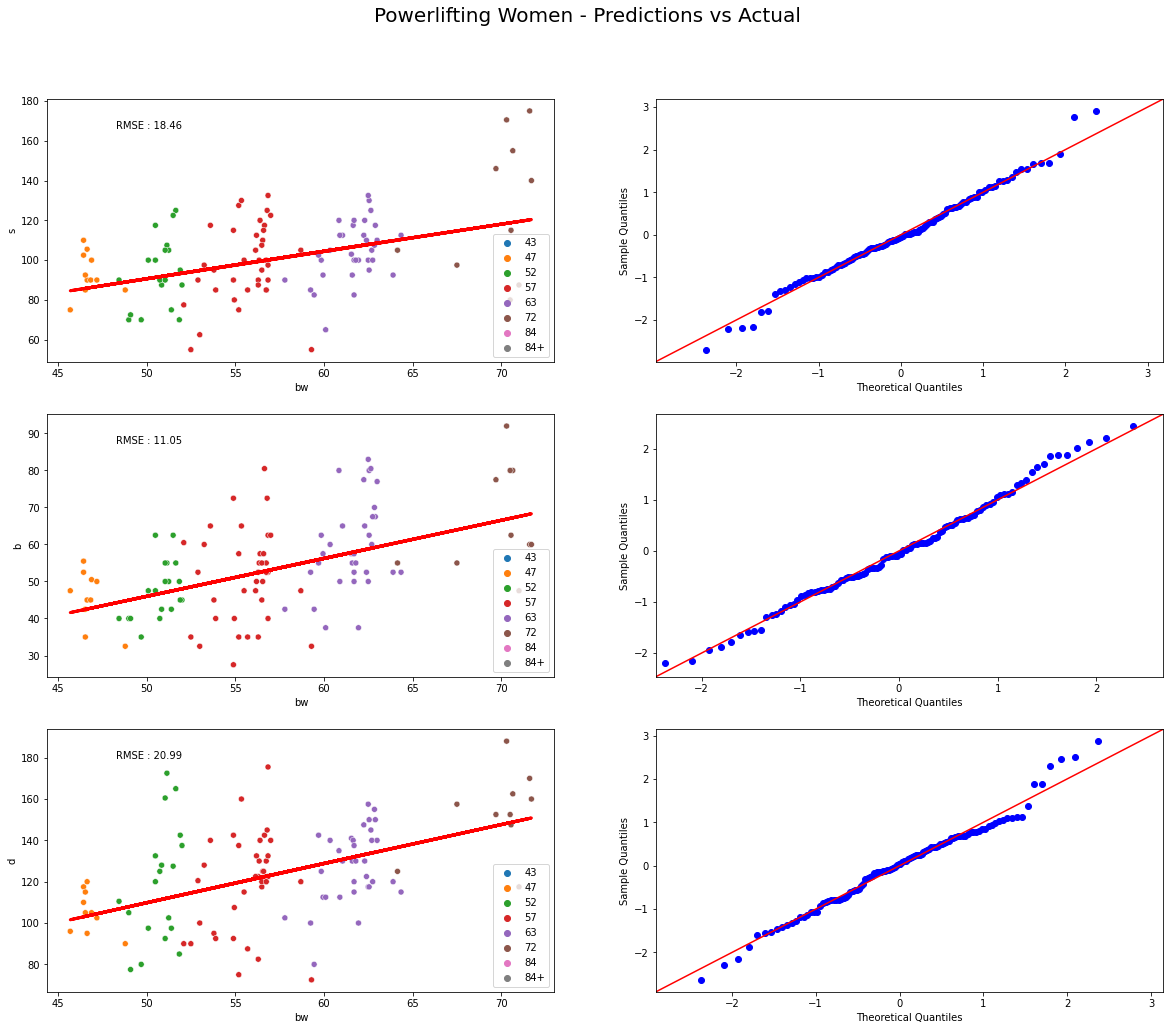

In [ ]:
prediction_plot(df_women_model,
                model_information['ypred_list'],
                model_information['error_list'], 
                model_information['rsquared_list'],
                model_information['residuals_list'],
                'Women',
                'women_model_3')

In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
ws = wb['model_women_charts']

img = openpyxl.drawing.image.Image('women_model_3.png')
img.anchor = 'A130'
ws.add_image(img)
wb.save('normative_values_updated.xlsx')

In [ ]:
import pymc3 as pm
import arviz as az

$$\begin{align}
\beta &\sim \mathcal{HalfNormal}(sigma = 2) \\
\sigma &\sim \mathcal{HalfNormal}(sigma = 2) \\
Deadlift &\sim \mathcal{Normal}(\beta\ \sqrt{X},  \sigma) \\
\end{align}$$  

In [ ]:
df_men_model['weight_index'] = pd.factorize(df_men_model['weight_cat'])[0] + 1
df_men_model['weight_index'] = df_men_model['weight_index'] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_women_model['weight_index'] = pd.factorize(df_women_model['weight_cat'])[0] + 1
df_women_model['weight_index'] = df_women_model['weight_index'] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def bayesian_model_building(df : pd.DataFrame , movement : str) -> az.from_pymc3:

  bw = df.loc[df[movement] > 0,].bw
  m = df.loc[df[movement] > 0,].b
  wi = df.loc[df[movement] > 0,].weight_index
  weight_cat_list = df.weight_cat.unique().to_list()

  output_path = '/content/gdrive/SPO_1819'

  coords = {
      "weight_cat": weight_cat_list,
      "observations": np.arange(len(bw))
  }


  movement_dict = {'s':'squat','b':'bench','d':'deadlift'}
  target = movement_dict[movement]

  with pm.Model(coords=coords) as varying_intercept_slope:
      weight_idx = pm.Data("weight_idx", wi , dims="observations")

      # Hyperpriors:
      a = pm.Normal("a", mu=0.0, sigma= 10.0)     #global intercept
      sigma_a = pm.HalfNormal("sigma_a", sigma = 5.0)

      b = pm.Normal("b", mu=0.0, sigma=1.0)     #global beta
      sigma_b = pm.HalfNormal("sigma_b", sigma =0.5)

      # Varying intercepts:
      za_weight = pm.Normal("za_weight", mu=0.0, sigma=1.0, dims="weight_cat")    # stratum intercept
      # Varying slopes:
      zb_weight = pm.Normal("zb_weight", mu=0.0, sigma=1.0, dims="weight_cat")    #stratum beta

      # Expected value per weight cat:
      theta = pm.Deterministic(name = "mean" , var = (a + 
                                                      [weight_idx] * sigma_b) * bw)
      
      # Model error:
      sigma = pm.HalfNormal("sigma", sigma = 10)

      y = pm.Normal(target, theta, sigma=sigma, observed= m, dims="observations")

  with varying_intercept_slope:
      varying_intercept_slope_idata = pm.sample(
          2000, tune=2000, target_accept=0.99, random_seed= 42 , cores = 4
      )
      posterior_predictive = pm.sample_posterior_predictive(varying_intercept_slope_idata)
      prior = pm.sample_prior_predictive()

      pm_data = az.from_pymc3(
          trace=varying_intercept_slope_idata,
          prior=prior,
          posterior_predictive=posterior_predictive
      )
      pick_insert = open(f'gdrive/MyDrive/SPO_1819/{target}_bayesian_model.pkl', 'wb')
      pickle.dump({"model": varying_intercept_slope, "trace": varying_intercept_slope_idata},pick_insert)
      pick_insert.close()

  return (varying_intercept_slope,pm_data)

In [ ]:
def bayesian_models(df : pd.DataFrame)-> dict:
  bayesian_models_dict = {}
  for movements in ['s','b','d']:
    bayesian_models_dict[movements] = bayesian_model_building(df = df , movement = movements)
  return bayesian_models_dict

In [ ]:
men_bayesian_models = bayesian_models(df_men_model)
women_bayesian_models = bayesian_models(df_women_model)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [ ]:
wb = openpyxl.load_workbook('normative_values_updated.xlsx')
wb.create_sheet('model_women_bayesian_models')
ws = wb['model_women_bayesian_models']

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e71805350>]],
      dtype=object)

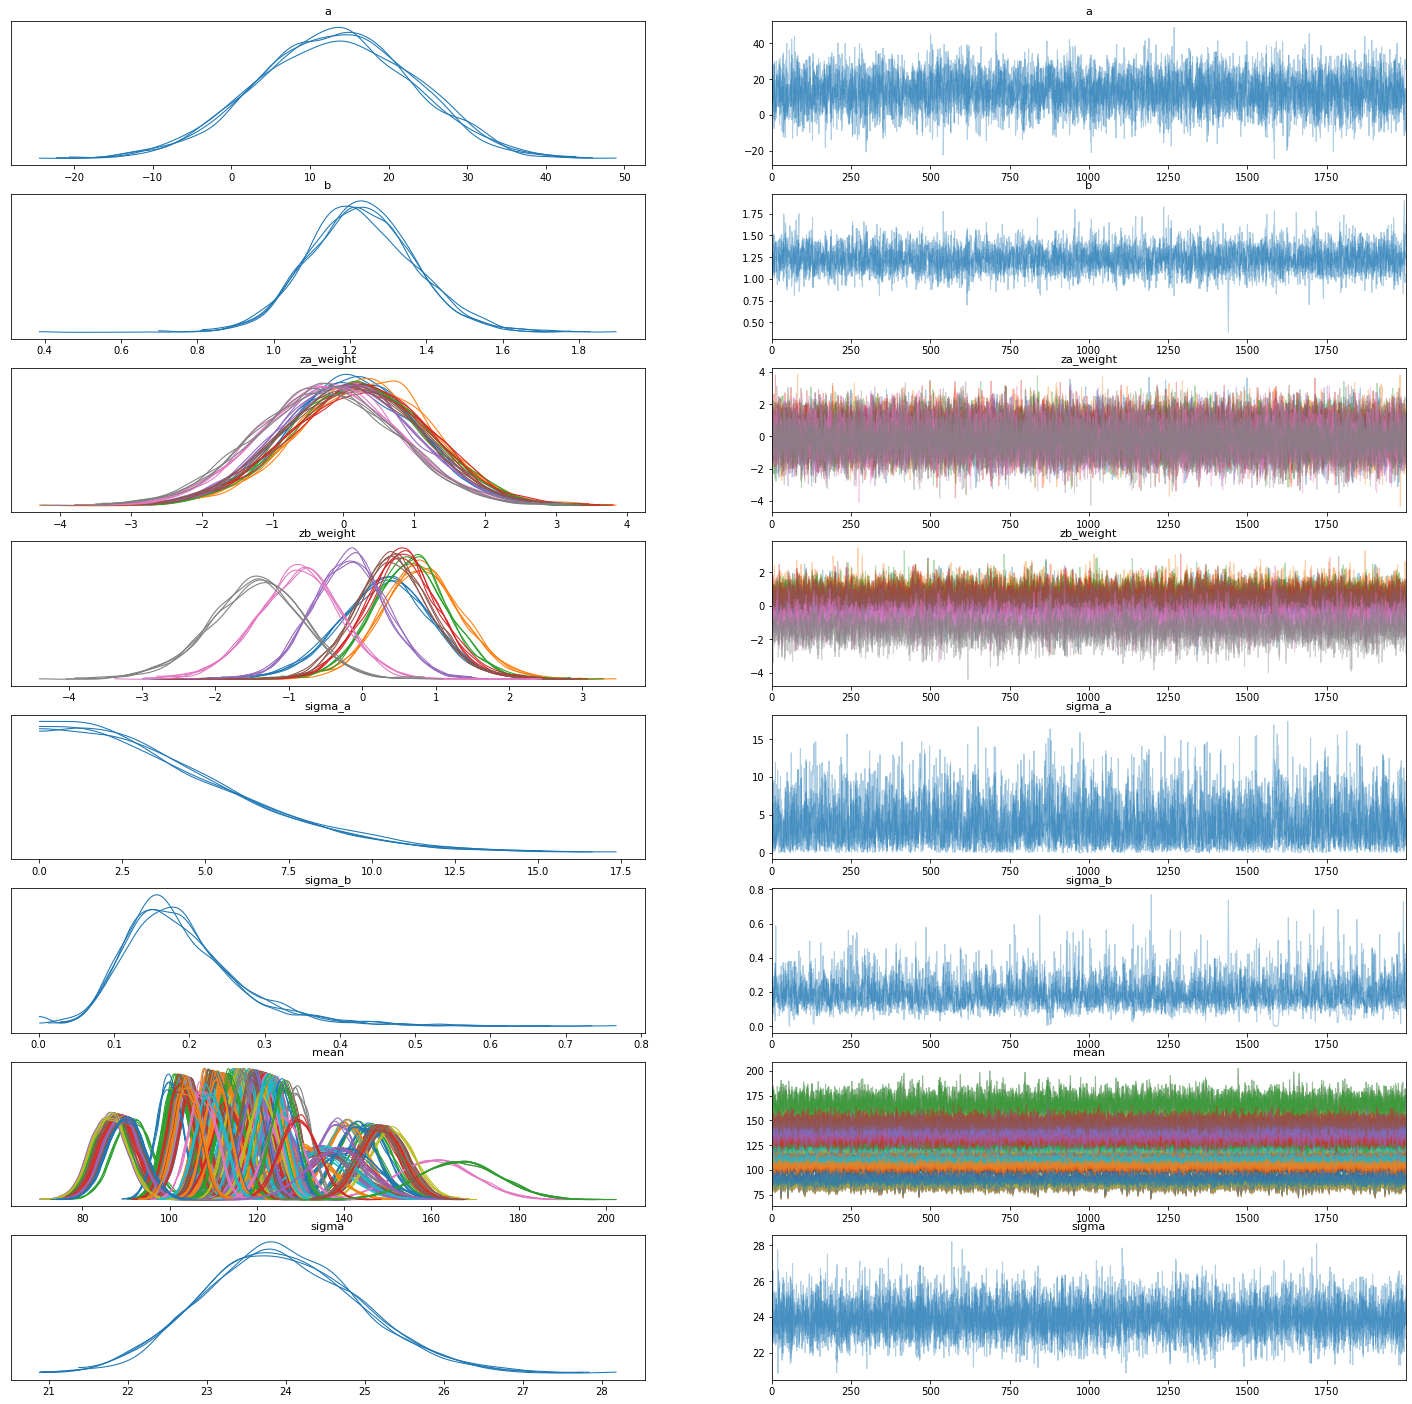

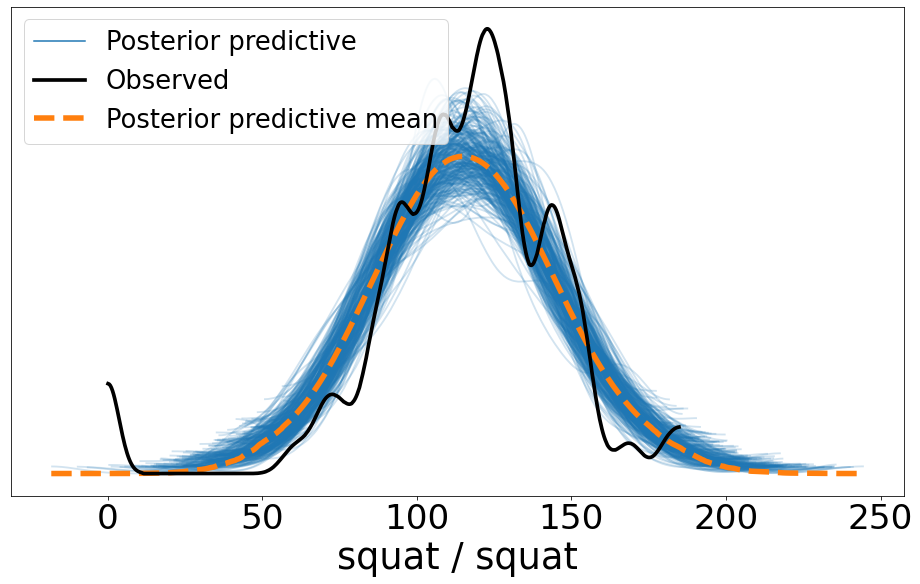

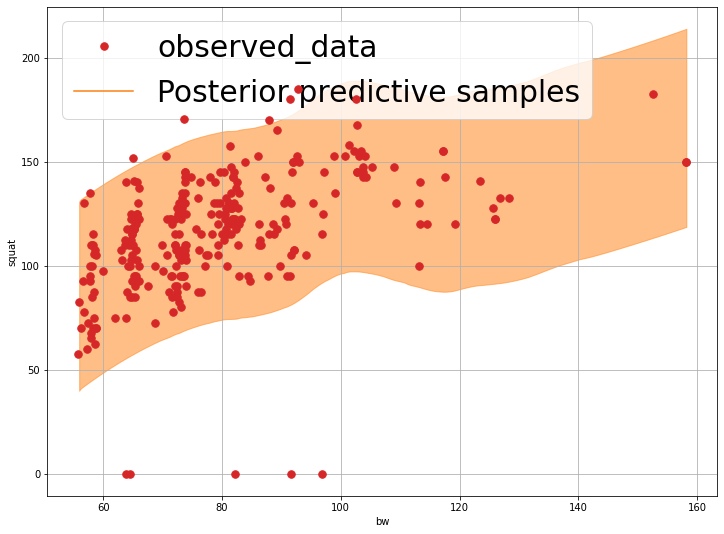

In [ ]:
# wb = openpyxl.load_workbook('normative_values_updated.xlsx')
# ws = wb['model_women_bayesian_models']
az.plot_trace(men_bayesian_models['s'][1]  , compact = True , figsize = (25,25) , chain_prop={"ls": "-"})
# plt.savefig('women_squat_trace_plot.png')

# wb = openpyxl.load_workbook('normative_values_updated.xlsx')
# ws = wb['model_women_bayesian_models']
# img = openpyxl.drawing.image.Image('women_squat_trace_plot.png')
# img.anchor = 'A1'
# ws.add_image(img)
# wb.save('normative_values_updated.xlsx')

# wb = openpyxl.load_workbook('normative_values_updated.xlsx')
# ws = wb['model_women_bayesian_models']
az.plot_ppc(men_bayesian_models['s'][1]  , num_pp_samples= 300, figsize = (16,9))
# plt.savefig('women_squat_ppc_plot.png')
# img = openpyxl.drawing.image.Image('women_squat_ppc_plot.png')
# img.anchor = 'A50'
# ws.add_image(img)
# wb.save('normative_values_updated.xlsx')


# wb = openpyxl.load_workbook('normative_values_updated.xlsx')
# ws = wb['model_women_bayesian_models']
az.plot_lm(idata= men_bayesian_models['s'][1] , y="squat", x= df_men_model[df_men_model['s']>0].bw, kind_pp="hdi", kind_model="hdi" , figsize = (12,9))
# plt.savefig('women_squat_lm_plot.png')

# img = openpyxl.drawing.image.Image('women_squat_lm_plot.png')
# img.anchor = 'A70'
# ws.add_image(img)
# wb.save('normative_values_updated.xlsx')

In [ ]:
az.summary(women_bayesian_models['b'][1] , ['a','b','sigma_a' , 'sigma_b' , 'sigma'])

In [ ]:
az.plot_trace(women_bayesian_models['b'][1]  , compact = True , figsize = (25,25) , chain_prop={"ls": "-"})

In [ ]:
az.plot_ppc(women_bayesian_models['b'][1]  , num_pp_samples= 300, figsize = (16,9))

In [ ]:
az.plot_lm(idata= women_bayesian_models['b'][1] , y="bench", x= df_women_model[df_women_model['b']>0].bw, kind_pp="hdi", kind_model="hdi" , figsize = (12,9))